**WEEK**-**1** **TASK**

# ai_task_management_dataset_10k (2).csv




**PERFORM EDA AND CLEAN DATA**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")

# Convert deadline to datetime
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')

# Feature Engineering
df['deadline_dayofweek'] = df['deadline'].dt.dayofweek
df['deadline_hour'] = df['deadline'].dt.hour

# Select features
features = [
    'estimated_duration_hours',
    'current_user_workload',
    'task_category',
    'deadline_dayofweek',
    'deadline_hour'
]

target = 'priority'

X = df[features]
y = df[target]

# Preprocessing: categorical encoding and missing value handling
categorical_features = ['task_category']
numeric_features = ['estimated_duration_hours', 'current_user_workload', 'deadline_dayofweek', 'deadline_hour']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        High       0.31      0.30      0.31       592
         Low       0.17      0.15      0.16       385
      Medium       0.52      0.55      0.53      1023

    accuracy                           0.40      2000
   macro avg       0.33      0.34      0.33      2000
weighted avg       0.39      0.40      0.40      2000

Confusion Matrix:
[[178  95 319]
 [118  59 208]
 [273 185 565]]


**APPLY NLP PREPROCESSING ON TASK DESCRIPTIONS**

In [ ]:
import re
import string

# Define basic stopwords manually (shortened for example)
basic_stopwords = set([
    'the', 'and', 'is', 'in', 'to', 'of', 'a', 'for', 'on', 'with', 'as',
    'by', 'at', 'from', 'an', 'be', 'this', 'that', 'it', 'or', 'are'
])

def simple_preprocess(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    tokens = text.split()  # simple whitespace tokenization
    tokens = [word for word in tokens if word not in basic_stopwords]  # remove stopwords
    return ' '.join(tokens)

# Apply to task_description
df['clean_task_description'] = df['task_description'].apply(simple_preprocess)

# Display a few results
df[['task_description', 'clean_task_description']].head()


,task_description,clean_task_description
0,Particular fight not help unit second economy.,particular fight not help unit second economy
1,Become station hair remember accept audience a...,become station hair remember accept audience a...
2,Like strategy argue there thing.,like strategy argue there thing
3,Some cause local again over perform including ...,some cause local again over perform including ...
4,Hundred large child whose.,hundred large child whose


**WEEK 2-TASK**

**TF-IDF WORD EMBEDDINGS**

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")

# Convert deadline to datetime and create new features
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
df['deadline_dayofweek'] = df['deadline'].dt.dayofweek
df['deadline_hour'] = df['deadline'].dt.hour

# Text preprocessing
stopwords = set([
    'the', 'and', 'is', 'in', 'to', 'of', 'a', 'for', 'on', 'with', 'as',
    'by', 'at', 'from', 'an', 'be', 'this', 'that', 'it', 'or', 'are'
])
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stopwords])

df['clean_task_description'] = df['task_description'].apply(clean_text)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf.fit_transform(df['clean_task_description'])

# Tabular features
tabular_features = df[['estimated_duration_hours', 'current_user_workload', 'task_category', 'deadline_dayofweek', 'deadline_hour']]
target = df['priority']

# Preprocessing for tabular data
categorical_features = ['task_category']
numerical_features = ['estimated_duration_hours', 'current_user_workload', 'deadline_dayofweek', 'deadline_hour']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = SimpleImputer(strategy='mean')

tabular_preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fit-transform tabular data
tabular_features_processed = tabular_preprocessor.fit_transform(tabular_features)

# Combine tabular and TF-IDF features
X_combined = np.hstack([
    tabular_features_processed.toarray() if hasattr(tabular_features_processed, "toarray") else tabular_features_processed,
    tfidf_features.toarray()
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, target, test_size=0.2, random_state=42)

# Train RandomForest with class balancing
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

        High       0.26      0.11      0.15       592
         Low       0.20      0.05      0.08       385
      Medium       0.51      0.84      0.64      1023

    accuracy                           0.47      2000
   macro avg       0.33      0.33      0.29      2000
weighted avg       0.38      0.47      0.39      2000



**CLASSIFICATION USING NAIVE BAYES AND SVM**

----- Naive Bayes -----
              precision    recall  f1-score   support

        High       0.29      0.03      0.05       592
         Low       0.00      0.00      0.00       385
      Medium       0.51      0.97      0.67      1023

    accuracy                           0.50      2000
   macro avg       0.27      0.33      0.24      2000
weighted avg       0.35      0.50      0.36      2000

----- SVM (LinearSVC) -----
              precision    recall  f1-score   support

        High       0.30      0.26      0.28       592
         Low       0.24      0.10      0.14       385
      Medium       0.52      0.68      0.59      1023

    accuracy                           0.44      2000
   macro avg       0.35      0.34      0.33      2000
weighted avg       0.40      0.44      0.41      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


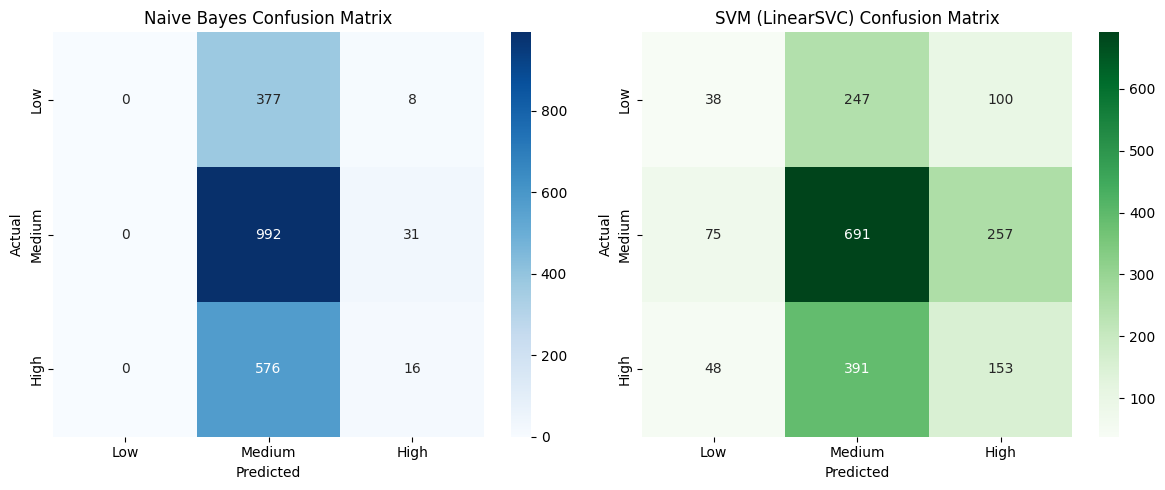

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")

# Simple text preprocessing
stopwords = set([
    'the', 'and', 'is', 'in', 'to', 'of', 'a', 'for', 'on', 'with', 'as',
    'by', 'at', 'from', 'an', 'be', 'this', 'that', 'it', 'or', 'are'
])
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stopwords])

df['clean_task_description'] = df['task_description'].apply(clean_text)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['clean_task_description'])
y = df['priority']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

# SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Evaluation Reports
print("----- Naive Bayes -----")
print(classification_report(y_test, nb_preds))
print("----- SVM (LinearSVC) -----")
print(classification_report(y_test, svm_preds))

# Confusion Matrices
nb_cm = confusion_matrix(y_test, nb_preds, labels=['Low', 'Medium', 'High'])
svm_cm = confusion_matrix(y_test, svm_preds, labels=['Low', 'Medium', 'High'])

# Plot Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('SVM (LinearSVC) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:

git init


**SETUP VERSION WITH GITHUB**

In [ ]:
# Step 1: Git config (use your GitHub email)
!git config --global user.email "your-email@example.com"
!git config --global user.name "GowthamiSM-2002"

# Step 2: Create project folder & enter it
!mkdir gowthami_project
%cd gowthami_project
!git init

# Step 3: Save a sample Python file (replace with real code if needed)
with open("classifier.py", "w") as f:
    f.write("# Sample ML code\nprint('Hello from Colab!')")

# Step 4: Add & commit
!git add .
!git commit -m "Initial commit from Colab"

# Step 5: Add GitHub remote (replace YOUR_TOKEN_HERE)
!git remote add origin https://ghp_YOUR_TOKEN_HERE@github.com/GowthamiSM-2002/gowthami.git

# Step 6: Push to GitHub
!git branch -M main
!git push -u origin main


**EVALUATE USING ACCURACY,PRECISION,RECALL**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")  # Use the correct local filename

# Convert deadline to datetime
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')

# Feature engineering
df['deadline_dayofweek'] = df['deadline'].dt.dayofweek
df['deadline_hour'] = df['deadline'].dt.hour

# Define features and target
features = [
    'estimated_duration_hours',
    'current_user_workload',
    'task_category',
    'deadline_dayofweek',
    'deadline_hour'
]
target = 'priority'

X = df[features]
y = df[target]

# Preprocessing
categorical_features = ['task_category']
numeric_features = ['estimated_duration_hours', 'current_user_workload', 'deadline_dayofweek', 'deadline_hour']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Build model pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall (weighted):", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.401
Precision (weighted): 0.3907502146702907
Recall (weighted): 0.401

Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.30      0.31       592
         Low       0.17      0.15      0.16       385
      Medium       0.52      0.55      0.53      1023

    accuracy                           0.40      2000
   macro avg       0.33      0.34      0.33      2000
weighted avg       0.39      0.40      0.40      2000

Confusion Matrix:
 [[178  95 319]
 [118  59 208]
 [273 185 565]]


**WEEK 3**

**IMPLEMENT PRIORITY PREDICTION MODEL USING RANDOM FOREST**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Load dataset
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")  # Adjust if needed

# Parse datetime and create new features
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
df['deadline_dayofweek'] = df['deadline'].dt.dayofweek
df['deadline_hour'] = df['deadline'].dt.hour

# Features and target
features = [
    'estimated_duration_hours',
    'current_user_workload',
    'task_category',
    'deadline_dayofweek',
    'deadline_hour'
]
target = 'priority'

X = df[features]
y = df[target]

# Encode target labels ('High', 'Medium', 'Low') -> (0, 1, 2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define preprocessing
numeric_features = ['estimated_duration_hours', 'current_user_workload', 'deadline_dayofweek', 'deadline_hour']
categorical_features = ['task_category']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# === RANDOM FOREST MODEL ===
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("==== Random Forest Results ====")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


# === XGBOOST MODEL ===
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print("\n==== XGBoost Results ====")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))


==== Random Forest Results ====
Accuracy: 0.401
Precision: 0.3907502146702907
Recall: 0.401
Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.30      0.31       592
         Low       0.17      0.15      0.16       385
      Medium       0.52      0.55      0.53      1023

    accuracy                           0.40      2000
   macro avg       0.33      0.34      0.33      2000
weighted avg       0.39      0.40      0.40      2000



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



==== XGBoost Results ====
Accuracy: 0.4275
Precision: 0.3839821132650545
Recall: 0.4275
Classification Report:
               precision    recall  f1-score   support

        High       0.30      0.24      0.27       592
         Low       0.17      0.09      0.12       385
      Medium       0.52      0.66      0.58      1023

    accuracy                           0.43      2000
   macro avg       0.33      0.33      0.32      2000
weighted avg       0.38      0.43      0.40      2000



**INTEGRATE WORKLOAD BALANCING LOGIC USING HEURISTIC OR ML APPROACH**

In [ ]:
def apply_workload_heuristic(row, predicted_priority_label, workload_threshold=0.8):
    """
    Adjust priority based on current user workload using a heuristic.
    """
    # Example: workload is from 0 (free) to 1 (overloaded)
    if row['current_user_workload'] >= workload_threshold:
        if predicted_priority_label == 'High':
            return 'Medium'  # De-escalate slightly
        elif predicted_priority_label == 'Medium':
            return 'Low'
    return predicted_priority_label

# Example use after prediction
X_test_copy = X_test.copy()
X_test_copy['predicted_priority'] = label_encoder.inverse_transform(y_pred_rf)
X_test_copy['adjusted_priority'] = X_test_copy.apply(
    lambda row: apply_workload_heuristic(row, row['predicted_priority']), axis=1
)


In [ ]:
# Create sample weights based on workload
sample_weights = 1.0 / (1 + X_train['current_user_workload'])

xgb_pipeline.named_steps['classifier'].fit(
    xgb_pipeline.named_steps['preprocessor'].transform(X_train),
    y_train,
    sample_weight=sample_weights
)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:34:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
df['urgency_score'] = df['estimated_duration_hours'] / (1.0 - df['current_user_workload'].clip(upper=0.99))
features.append('urgency_score')


**APPLY GRIDSEARCHCV FOR HYPERPARAMETER TUNING**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Load data
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")

# Preprocess deadlines
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
df['deadline_dayofweek'] = df['deadline'].dt.dayofweek
df['deadline_hour'] = df['deadline'].dt.hour

# Encode target
label_encoder = LabelEncoder()
df['priority_encoded'] = label_encoder.fit_transform(df['priority'])

# Define features and target
features = [
    'estimated_duration_hours',
    'current_user_workload',
    'task_category',
    'deadline_dayofweek',
    'deadline_hour'
]
target = 'priority_encoded'

X = df[features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['estimated_duration_hours', 'current_user_workload', 'deadline_dayofweek', 'deadline_hour']
categorical_features = ['task_category']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Build XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Train model
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred = xgb_pipeline.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# === Apply Heuristic ===

def adjust_priority_with_workload(row, original_label):
    workload = row['current_user_workload']
    if workload >= 0.8:
        if original_label == 'High':
            return 'Medium'
        elif original_label == 'Medium':
            return 'Low'
    return original_label

X_test_copy = X_test.copy()
X_test_copy['original_pred'] = y_pred_labels
X_test_copy['adjusted_pred'] = X_test_copy.apply(
    lambda row: adjust_priority_with_workload(row, row['original_pred']), axis=1
)

# === Evaluation ===

print("=== XGBoost - Before Workload Adjustment ===")
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("Precision:", precision_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

print("\n=== XGBoost - After Workload Adjustment ===")
adjusted_preds = X_test_copy['adjusted_pred']
print("Accuracy:", accuracy_score(y_test_labels, adjusted_preds))
print("Precision:", precision_score(y_test_labels, adjusted_preds, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test_labels, adjusted_preds, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test_labels, adjusted_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:37:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost - Before Workload Adjustment ===
Accuracy: 0.4275
Precision: 0.3839821132650545
Recall: 0.4275

Classification Report:
               precision    recall  f1-score   support

        High       0.30      0.24      0.27       592
         Low       0.17      0.09      0.12       385
      Medium       0.52      0.66      0.58      1023

    accuracy                           0.43      2000
   macro avg       0.33      0.33      0.32      2000
weighted avg       0.38      0.43      0.40      2000


=== XGBoost - After Workload Adjustment ===
Accuracy: 0.262
Precision: 0.28919921064271376
Recall: 0.262

Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00       592
         Low       0.19      0.74      0.30       385
      Medium       0.49      0.23      0.32      1023

    accuracy                           0.26      2000
   macro avg       0.23      0.32      0.21      2000
weighted avg       0.29      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
}

# Wrap your pipeline with GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best Cross-Validation Accuracy: 0.47574965544910786
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.05      0.08       592
           1       0.00      0.00      0.00       385
           2       0.51      0.95      0.67      1023

    accuracy                           0.50      2000
   macro avg       0.27      0.33      0.25      2000
weighted avg       0.35      0.50      0.37      2000



In [ ]:
print(df.columns.tolist())


['task_id', 'task_description', 'priority', 'user_id', 'deadline', 'estimated_duration_hours', 'current_user_workload', 'task_category', 'deadline_dayofweek', 'deadline_hour', 'priority_encoded']


**WEEK 4**

**TASK CLASSIFICATION AND PRIORITY PREDICTION**


In [ ]:
X_text = df['task_description']
y_text = df['priority_encoded']  # or 'priority' if you're classifying labels directly

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# Define model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

task_classification_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', LinearSVC())
])

# Fit model
task_classification_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('clf', LinearSVC())])

In [ ]:

import re
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 1: Clean text descriptions
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\W+', ' ', text)
    return text.strip()

df['clean_task_description'] = df['task_description'].apply(clean_text)

# Step 2: Define features
categorical_features = ['task_category']
numeric_features = ['estimated_duration_hours', 'current_user_workload', 'deadline_dayofweek', 'deadline_hour']
text_feature = 'clean_task_description'

# Step 3: Split features and target
X = df[numeric_features + categorical_features + [text_feature]]
y = df['priority_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build transformers
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000))
])

tabular_transformer = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

# Step 5: Combine everything
preprocessor = ColumnTransformer(transformers=[
    ('tabular', tabular_transformer, numeric_features + categorical_features),
    ('text', text_transformer, text_feature)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Step 6: Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 7: Evaluate
print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", grid_search.score(X_test, y_test))

y_pred = grid_search.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Test Accuracy: 0.5115
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       592
           1       0.00      0.00      0.00       385
           2       0.51      1.00      0.68      1023

    accuracy                           0.51      2000
   macro avg       0.17      0.33      0.23      2000
weighted avg       0.26      0.51      0.35      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Collect user input (in notebook input fields)
estimated_duration = float(input("Estimated Duration (hours): "))
current_workload = float(input("Current User Workload: "))
task_category = input("Task Category (e.g., Bug, Feature): ")
deadline_day = input("Deadline Day (e.g., Monday): ")
deadline_hour = int(input("Deadline Hour (0–23): "))

# Map weekday string to number (0=Monday, 6=Sunday)
day_map = {
    "monday": 0, "tuesday": 1, "wednesday": 2,
    "thursday": 3, "friday": 4, "saturday": 5, "sunday": 6
}
deadline_dayofweek = day_map[deadline_day.strip().lower()]


Estimated Duration (hours): 0
Current User Workload: 1
Task Category (e.g., Bug, Feature): ug
Deadline Day (e.g., Monday): monday
Deadline Hour (0–23): 7


In [ ]:
# Format input as DataFrame
input_data = pd.DataFrame([{
    'estimated_duration_hours': estimated_duration,
    'current_user_workload': current_workload,
    'task_category': task_category,
    'deadline_dayofweek': deadline_dayofweek,
    'deadline_hour': deadline_hour
}])

# Predict using trained pipeline
predicted_priority = clf.predict(input_data)[0]
print(f"📌 Predicted Task Priority: {predicted_priority}")


📌 Predicted Task Priority: High


In [ ]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)


In [ ]:
import pickle

# Only save the classifier or pipeline — NOT raw data
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)  # make sure clf is your model object


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install twilio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:00


In [ ]:
!pip install gradio

**DASHBOARD OR OUTPUT SUMMARY**

In [ ]:
import gradio as gr
import pandas as pd
import os
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Load dataset
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
df['deadline_dayofweek'] = df['deadline'].dt.dayofweek
df['deadline_hour'] = df['deadline'].dt.hour
df['task_urgency'] = (df['deadline'] - pd.Timestamp.now()).dt.total_seconds() / 3600

features = [
    'estimated_duration_hours',
    'task_urgency',
    'task_category',
    'deadline_dayofweek',
    'deadline_hour'
]
target = 'priority'

X = df[features]
y = df[target]

# Preprocessing
categorical_features = ['task_category']
numeric_features = ['estimated_duration_hours', 'task_urgency', 'deadline_dayofweek', 'deadline_hour']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
clf.fit(X, y)

# Task history file
history_file = "task_history.csv"

def save_history_entry(entry):
    df = pd.DataFrame([entry])
    df.to_csv(history_file, mode='a', header=not os.path.exists(history_file), index=False)

def load_history():
    if os.path.exists(history_file):
        return pd.read_csv(history_file)
    return pd.DataFrame(columns=["Task", "Category", "Duration", "Urgency", "Start", "Deadline", "Assignee", "Priority", "Status"])

# Reminder message
def get_reminder_message(deadline_str, status, start_date_str):
    try:
        deadline = pd.to_datetime(deadline_str)
        start_date = pd.to_datetime(start_date_str)
        now = datetime.now()

        if status == "Completed":
            return "✅ Task completed!"

        if deadline.date() == start_date.date():
            return "🛑 Start and Deadline are the Same Day! Plan your time carefully!"

        time_left = deadline - now
        if time_left < timedelta(hours=1):
            return "⏰ URGENT! Less than 1 hour left!"
        elif time_left < timedelta(hours=24):
            return "⚠️ Deadline within 24 hours."
        else:
            return "🕒 You're on track."
    except:
        return "❌ Invalid date format."

# Task reassignment logic
def reassign_task_if_incomplete(status, current_assignee):
    if status != "Completed":
        return f"🔄 Reassigned from {current_assignee} to Backup_User"
    return f"✅ Task stays with {current_assignee}"

# Main dashboard logic
def ai_task_manager(task_name, estimated_duration_hours,
                    task_category, deadline_str, status, start_date_str, assignee):
    try:
        deadline = pd.to_datetime(deadline_str)
        deadline_dayofweek = deadline.dayofweek
        deadline_hour = deadline.hour
        task_urgency = (deadline - datetime.now()).total_seconds() / 3600
    except:
        return "❌ Error: Invalid deadline format", "", "", ""

    input_df = pd.DataFrame([{
        'estimated_duration_hours': estimated_duration_hours,
        'task_urgency': task_urgency,
        'task_category': task_category,
        'deadline_dayofweek': deadline_dayofweek,
        'deadline_hour': deadline_hour
    }])

    prediction = clf.predict(input_df)[0]
    reminder = get_reminder_message(deadline_str, status, start_date_str)
    reassignment_info = reassign_task_if_incomplete(status, assignee)

    try:
        start_date = pd.to_datetime(start_date_str)
        deadline = pd.to_datetime(deadline_str)
        days_left = (deadline - start_date).days
        days_info = f"⏳ **Time Between Start and Deadline**: {days_left} day(s)"
    except:
        days_info = "⏳ **Time Between Start and Deadline**: Invalid date(s)"

    summary = (
        f"📌 **Task**: {task_name}\n"
        f"📂 **Category**: {task_category}\n"
        f"🕒 **Estimated Duration**: {estimated_duration_hours} hrs\n"
        f"🔥 **Task Urgency (hours to deadline)**: {round(task_urgency, 2)} hrs\n"
        f"📅 **Start Date**: {start_date_str}\n"
        f"🗓️ **Deadline**: {deadline_str}\n"
        f"👤 **Assigned To**: {assignee}\n"
        f"{days_info}\n"
        f"🚦 **Status**: {status}\n"
        f"{reassignment_info}"
    )

    task_data = {
        "Task": task_name,
        "Category": task_category,
        "Duration": estimated_duration_hours,
        "Urgency": task_urgency,
        "Start": start_date_str,
        "Deadline": deadline_str,
        "Assignee": assignee,
        "Priority": prediction,
        "Status": status
    }

    save_history_entry(task_data)

    return prediction, status, reminder, summary

# Options
task_categories = df['task_category'].dropna().unique().tolist()
status_options = ["Not Started", "In Progress", "Completed"]
assignees = ["Alice", "Bob", "Charlie", "David"]

# Gradio UI
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## 🌟 AI Task Management System")
    gr.Markdown("> Assign tasks, predict priority, and get smart reminders.")

    with gr.Column():
        with gr.Row():
            task_name = gr.Textbox(label="📝 Task Name")
            task_category = gr.Dropdown(task_categories, label="📂 Task Category")

        with gr.Row():
            estimated_duration = gr.Number(label="⏱️ Estimated Duration (hours)")

        start_date_input = gr.Textbox(label="📅 Start Date (YYYY-MM-DD HH:MM)", placeholder="e.g. 2025-05-30 09:00")
        deadline_input = gr.Textbox(label="🗓️ Deadline (YYYY-MM-DD HH:MM)", placeholder="e.g. 2025-06-01 14:00")
        task_status = gr.Dropdown(status_options, label="🚦 Task Status")
        assignee_input = gr.Dropdown(assignees, label="👤 Assign To")

        predict_btn = gr.Button("🚀 Predict Priority & Update")

        gr.Markdown("---")

        with gr.Row():
            predicted_priority = gr.Textbox(label="⭐ Predicted Priority", interactive=False)
            status_display = gr.Textbox(label="📌 Current Status", interactive=False)
            reminder_display = gr.Textbox(label="⏰ Reminder", interactive=False)

        task_summary = gr.Markdown()

        predict_btn.click(
            fn=ai_task_manager,
            inputs=[task_name, estimated_duration, task_category, deadline_input, task_status, start_date_input, assignee_input],
            outputs=[predicted_priority, status_display, reminder_display, task_summary]
        )

    gr.Markdown("---")
    gr.Markdown("### 📜 Task History")

    task_history_display = gr.Dataframe(
        value=load_history(),
        interactive=False,
        label="Saved Task History"
    )

    refresh_btn = gr.Button("🔁 Refresh Task History")
    refresh_btn.click(fn=load_history, inputs=[], outputs=[task_history_display])

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://84fc04465174d4218b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**COMPILE PERFORMACE METRICS,GRAPHS,AD RESULTS**


----- Random Forest -----
              precision    recall  f1-score   support

        High       0.29      0.27      0.28       592
         Low       0.26      0.21      0.23       385
      Medium       0.52      0.57      0.54      1023

    accuracy                           0.41      2000
   macro avg       0.35      0.35      0.35      2000
weighted avg       0.40      0.41      0.40      2000


----- Naive Bayes -----
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       592
         Low       0.00      0.00      0.00       385
      Medium       0.51      1.00      0.68      1023

    accuracy                           0.51      2000
   macro avg       0.17      0.33      0.23      2000
weighted avg       0.26      0.51      0.35      2000


----- SVM (LinearSVC) -----
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       592
         Low       0.00      0.00      0.00     

<Figure size 1000x600 with 0 Axes>

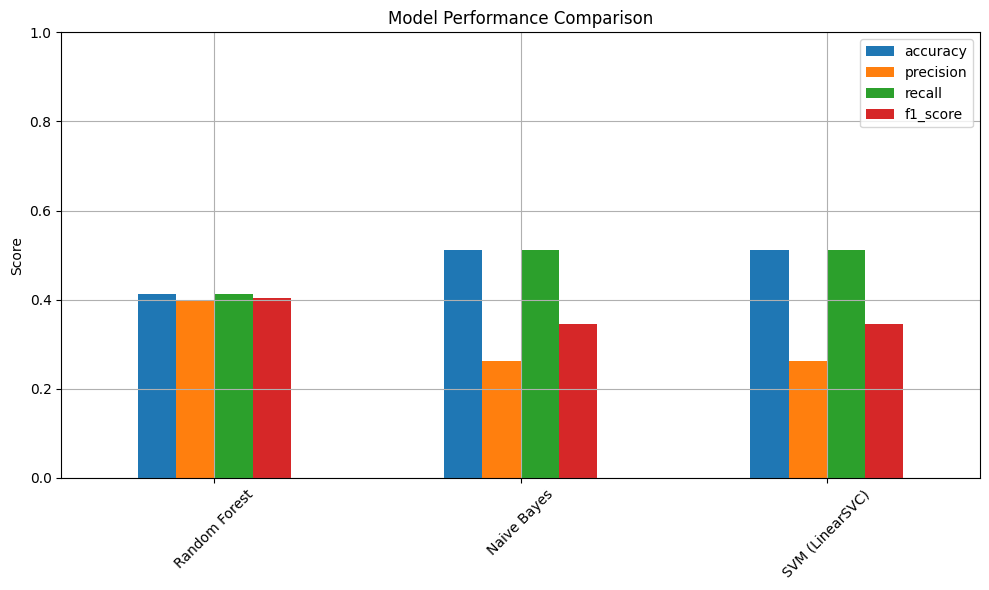

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv("/ai_task_management_dataset_10k (2).csv")  # Update this path
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')
df['deadline_dayofweek'] = df['deadline'].dt.dayofweek
df['deadline_hour'] = df['deadline'].dt.hour
df['task_urgency'] = (df['deadline'] - pd.Timestamp.now()).dt.total_seconds() / 3600

features = ['estimated_duration_hours', 'task_urgency', 'task_category', 'deadline_dayofweek', 'deadline_hour']
target = 'priority'
X = df[features]
y = df[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
categorical_features = ['task_category']
numeric_features = ['estimated_duration_hours', 'task_urgency', 'deadline_dayofweek', 'deadline_hour']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM (LinearSVC)": Pipeline([
        ('svc', LinearSVC(max_iter=5000))
    ])
}

# Store results
results = {}

# Train, predict and evaluate
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': acc,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score']
    }
    print(f"\n----- {name} -----")
    print(classification_report(y_test, y_pred, zero_division=0))

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\n📊 Summary of Model Performance:\n", results_df)

# Plotting
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ✅ AI Task Management Dashboard with Planning, Prioritization, and Management

import gradio as gr
from datetime import datetime, timedelta
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px

# In-memory history
task_history = []

# Dummy prediction logic (replace with model if needed)
def predict_priority(duration, urgency, category):
    if urgency <= 1:
        return "High"
    elif duration > 2:
        return "Medium"
    else:
        return "Low"

def get_urgency(start, end):
    now = datetime.now()
    remaining = (end - now).total_seconds() / 3600
    return round(remaining, 2)

def check_notifications():
    overdue = []
    today = datetime.now().strftime("%Y-%m-%d")
    for task in task_history:
        if task["Status"] != "Completed" and task["Deadline"] < today:
            overdue.append(task["Name"])
    if overdue:
        return f"⚠️ Overdue Tasks: {', '.join(overdue)}"
    return "✅ All tasks are on track!"

def plan_task(name, duration, category, start_date, deadline_date, status, assigned_to):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    deadline = datetime.strptime(deadline_date, "%Y-%m-%d")
    urgency = get_urgency(start, deadline)
    priority = predict_priority(duration, urgency, category)

    summary = f"Task '{name}' assigned to {assigned_to}\nStatus: {status}\nCategory: {category}\nDuration: {duration} hrs\nUrgency: {urgency} hrs left\nPredicted Priority: {priority}"

    task = {
        "Name": name,
        "Duration": duration,
        "Category": category,
        "Start Date": start_date,
        "Deadline": deadline_date,
        "Urgency (hrs)": urgency,
        "Priority": priority,
        "Status": status,
        "Assigned To": assigned_to
    }
    task_history.append(task)
    return summary

def view_history():
    if not task_history:
        return "No tasks yet."
    df = pd.DataFrame(task_history)
    return df

def report_to_manager():
    if not task_history:
        return "No data to report."
    df = pd.DataFrame(task_history)
    summary = df.groupby("Status").size().to_dict()
    message = "📤 Report Summary Sent to Manager:\n"
    for status, count in summary.items():
        message += f"- {status}: {count} tasks\n"
    return message

def plot_priority_distribution():
    if not task_history:
        return None
    df = pd.DataFrame(task_history)
    fig, ax = plt.subplots()
    df["Priority"].value_counts().plot(kind="bar", ax=ax, color="skyblue")
    ax.set_title("Task Priority Distribution")
    return fig

def daily_productivity_chart():
    if not task_history:
        return None
    df = pd.DataFrame(task_history)
    df["Start Date"] = pd.to_datetime(df["Start Date"])
    count_per_day = df.groupby(df["Start Date"].dt.date).size()
    fig, ax = plt.subplots()
    count_per_day.plot(kind="bar", ax=ax, color="lightgreen")
    ax.set_title("Daily Planned Tasks")
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Tasks")
    return fig

def task_calendar_gantt():
    if not task_history:
        return None
    df = pd.DataFrame(task_history)
    df['Start Date'] = pd.to_datetime(df['Start Date'])
    df['Deadline'] = pd.to_datetime(df['Deadline'])
    fig = px.timeline(df, x_start="Start Date", x_end="Deadline", y="Name", color="Assigned To")
    fig.update_yaxes(autorange="reversed")
    return fig

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("""
    # 🤖 AI Task Planner Dashboard
    ### Plan, Prioritize, and Manage Tasks with AI Assistance
    """)

    user = gr.Dropdown(["Manager", "Team Lead", "QA"], label="Login As", value="Team Lead")

    with gr.Row():
        name = gr.Textbox(label="📝 Task Name")
        duration = gr.Slider(0.5, 8.0, value=1.0, step=0.5, label="Estimated Duration (hrs)")
        category = gr.Dropdown(["Development", "Testing", "Meeting", "Documentation"], label="Task Category")

    with gr.Row():
        start_date = gr.Textbox(label="Start Date (YYYY-MM-DD)", value=datetime.now().strftime("%Y-%m-%d"))
        deadline_date = gr.Textbox(label="Deadline Date (YYYY-MM-DD)")

    with gr.Row():
        status = gr.Dropdown(["Pending", "In Progress", "Completed"], label="Status")
        assigned_to = gr.Textbox(label="Assigned To")

    output = gr.Textbox(label="📋 Task Summary")
    plan_btn = gr.Button("🧠 Plan Task")
    plan_btn.click(fn=plan_task, inputs=[name, duration, category, start_date, deadline_date, status, assigned_to], outputs=output)

    gr.Markdown("## 📊 Task Management Overview")
    view_btn = gr.Button("📄 View All Tasks")
    table_output = gr.Dataframe()
    view_btn.click(fn=view_history, inputs=[], outputs=table_output)

    chart_btn = gr.Button("📊 View Priority Distribution")
    chart_output = gr.Plot()
    chart_btn.click(fn=plot_priority_distribution, inputs=[], outputs=chart_output)

    gr.Markdown("## 📆 Visual Insights")
    daily_btn = gr.Button("📅 View Daily Productivity")
    daily_output = gr.Plot()
    daily_btn.click(fn=daily_productivity_chart, inputs=[], outputs=daily_output)

    gantt_btn = gr.Button("📋 Task Calendar View (Gantt Chart)")
    gantt_output = gr.Plot()
    gantt_btn.click(fn=task_calendar_gantt, inputs=[], outputs=gantt_output)

    gr.Markdown("## 🔔 Smart Notifications")
    notify_btn = gr.Button("Check Overdue Notifications")
    notify_output = gr.Textbox(label="⏰ Notifications")
    notify_btn.click(fn=check_notifications, outputs=notify_output)

    gr.Markdown("## 📨 Report to Manager")
    report_btn = gr.Button("📤 Send Report Summary")
    report_output = gr.Textbox(label="📨 Report Status")
    report_btn.click(fn=report_to_manager, outputs=report_output)

# To launch:
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d453ee02b0317d8160.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
